# Portfolio Analyzer overview

Portfolio Analyzer is a python library built to make easy portfolio analysis. In this Notebook we are going to see few examples. First things first. You can install Portfolio Analyzer with pip, so

In [1]:
#%%bash
#pip install git+https://github.com/Tokukawa/PortfolioAnalyzer.git

The first thing we need in order to analyze porfolio is data. We can use the function `yahoo2pandas`. This function take a list of tickers and return a pandas dataframe

In [2]:
from portfolio_analyzer.stocks_data_loader import yahoo2pandas

In [3]:
tickers = ['SPXL', 'TMF', 'UGL']
data = yahoo2pandas(tickers, frequency='daily')

In [4]:
data.head()

,SPXL,TMF,UGL
formatted_date,,,
2009-04-16,2.415000,14.5350,29.920000
2009-04-17,2.470000,13.8850,29.440001
2009-04-20,2.152500,14.7275,30.690001
2009-04-21,2.278333,14.2825,30.559999
2009-04-22,2.237500,13.7950,30.889999


By default `yahoo2pandas` return all possible data from yahoo. You can specify range of time you want and the frequency. Once we obtained the data, we can optimize our portfolio according to some most common algorithms. Up this moment you can use only `minimal_variance`, `risk_parity` and `approximated_max_kelly`.

In [5]:
from portfolio_analyzer.optimizers import approximated_max_kelly, minimal_variance, risk_parity

In [6]:
minimal_variance(data)

,SPXL,TMF,UGL
0,0.301606,0.351565,0.346829


In [7]:
risk_parity(data)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.2903198400221532e-14
            Iterations: 21
            Function evaluations: 108
            Gradient evaluations: 21


,SPXL,TMF,UGL
0,0.312304,0.348332,0.339364


In [8]:
approximated_max_kelly(data)

,SPXL,TMF,UGL
0,0.308406,0.354138,0.337455


We can see how our portfolio would perform with `NaiveBackTest`.

In [9]:
from portfolio_analyzer.backtest import NaiveBackTest
from portfolio_analyzer.utils import portfolio2dic

In [10]:
my_portfolio = portfolio2dic(approximated_max_kelly(data))

In [11]:
backtest = NaiveBackTest(my_portfolio, data)

In [12]:
max_kelly_backtest = backtest.run()

We can perform some measures on the back test and we can plot it.

In [13]:
%matplotlib inline
from portfolio_analyzer.metrics import MainMetrics

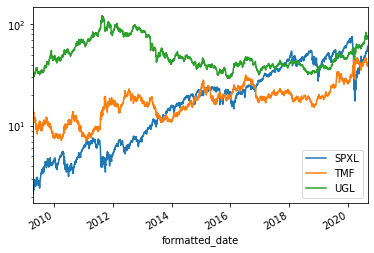

In [14]:
data.plot(logy=True)

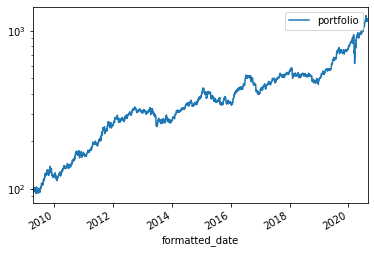

In [15]:
max_kelly_backtest.plot(logy=True)

In [16]:
benchmark_data = yahoo2pandas(['VTI'], frequency='daily')
measures = MainMetrics(benchmark=benchmark_data)

In [17]:
MainMetrics(benchmark_data).estimate(max_kelly_backtest)

,portfolio
alpha,0.154421
average arithmetic return,0.242679
average geometric return,0.244589
benchmark correlation,0.425570
beta,0.520469
max draw down,-0.342332
relative draw down,0.978082
relative return,1.857434
relative sharpe ratio,1.421196
relative variance,1.495398


But I want to perform a proper out-of-sample back test before rebalancing my portfolio. We can use the class `OutOfSampleBackTest`. First of all we need to know how many times we can split the dataset.

In [18]:
import pandas as pd
from portfolio_analyzer.utils import factors

Before starting my out of sample back test I neee to know how many eway I can split my data. I can know it with `factors` function 

In [19]:
factors(len(data))

[1, 2, 4, 8, 16, 179, 358, 716, 1432, 2864]

I can split my data in all the factors shown above!

In [20]:
SPLITS = 358

Now we can make a proper outofsample backtest.

In [21]:
from portfolio_analyzer.backtest import OutOfSampleBackTest

In [22]:
oos_backtest = OutOfSampleBackTest(data, minimal_variance, SPLITS, past_blocks=3, method='asym-blocks')

In [23]:
out_of_sample_portfolio = oos_backtest.run()

In [24]:
MainMetrics(benchmark_data).estimate(out_of_sample_portfolio)

,portfolio
alpha,0.136197
average arithmetic return,0.208964
average geometric return,0.206054
benchmark correlation,0.344921
beta,0.378661
max draw down,-0.267612
relative draw down,0.808612
relative return,1.424514
relative sharpe ratio,1.236114
relative variance,1.223791


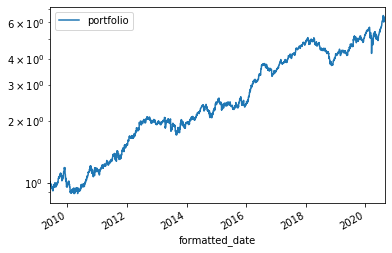

In [25]:
out_of_sample_portfolio.plot(logy=True)

I can even define my own strategy!

In [26]:
def custom_portfolio(data):
    return pd.DataFrame({'SPXL': [0.36], 'TMF':[0.48], 'UGL':[0.16]})

In [27]:
oos_backtest = OutOfSampleBackTest(data, custom_portfolio, SPLITS, past_blocks=4, method='asym-blocks')

In [28]:
out_of_sample_portfolio = oos_backtest.run()

We can get the actual out of sample performance the same way we did before.

In [29]:
MainMetrics(benchmark_data).estimate(out_of_sample_portfolio)

,portfolio
alpha,0.167857
average arithmetic return,0.234202
average geometric return,0.237923
benchmark correlation,0.310753
beta,0.334218
max draw down,-0.215151
relative draw down,0.650097
relative return,1.628393
relative sharpe ratio,1.402954
relative variance,1.173468


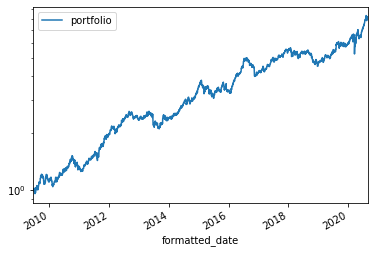

In [30]:
out_of_sample_portfolio.plot(logy=True)

I can even detect trends. For trend detection we can use the function l1filter.

In [32]:
from portfolio_analyzer.filtering import l1filter, l2filter

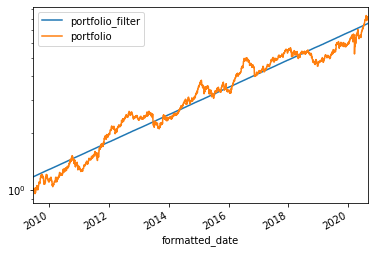

In [33]:
filtered, test = l1filter(out_of_sample_portfolio, delta=1E5)
filtered.plot(logy=True)

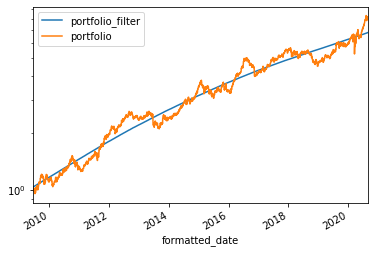

In [35]:
filtered, test = l2filter(out_of_sample_portfolio, delta=1E5)
filtered.plot(logy=True)

In [36]:
filtered.head()

,portfolio_filter,portfolio
formatted_date,,
2009-06-15,1.034321,1.000000
2009-06-16,1.035356,1.015936
2009-06-17,1.036392,1.005799
2009-06-18,1.037429,0.991149
2009-06-19,1.038467,1.013210


Whenever we perform a trend detection the test of stationarity is performed on the residuals. We can see the statistics as a pandas dataframe.

In [37]:
test['portfolio']

,portfolio
ADF Test Statistic,-2.949423
P-Value,0.039895
Lags Used,9.000000
Observations Used,2461.000000
Critical Value (1%),-3.433010
Critical Value (5%),-2.862715
Critical Value (10%),-2.567396


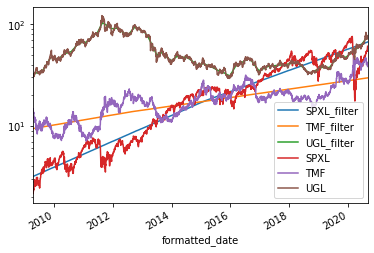

In [38]:
filtered, test = l1filter(data, delta=[1E4, 1E4, 1E1])
filtered.plot(logy=True)

In [39]:
test.keys()

dict_keys(['SPXL', 'TMF', 'UGL'])

In [40]:
test['SPXL']

,SPXL
ADF Test Statistic,-3.843767
P-Value,0.002490
Lags Used,27.000000
Observations Used,2836.000000
Critical Value (1%),-3.432658
Critical Value (5%),-2.862560
Critical Value (10%),-2.567313
